# FRUIT CLASSIFICATION

If running on Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install extra libs for colab
!pip install rembg

# change dir
%cd /content/drive/Othercomputers/MacBook/gdrive_sync/fruit_360

Import libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob
import random, io, joblib
import seaborn as sns
from os.path import join

from sklearn import metrics

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.applications import vgg16, resnet50, xception, efficientnet

import rembg, PIL

In [3]:
# Set plotting style of matplotlib
plt.style.use('seaborn-v0_8-darkgrid')

# Exploratory Data Analysis

In [4]:
# Directories of train and test set
train_dir = 'fruits-360_dataset_trimmed/Training'
test_dir = 'fruits-360_dataset_trimmed/Test'

print(f'Classes in train set: { len(glob(train_dir + "/*")) }')
print(f'Classes in test set: { len(glob(test_dir + "/*")) }')

Classes in train set: 20
Classes in test set: 20


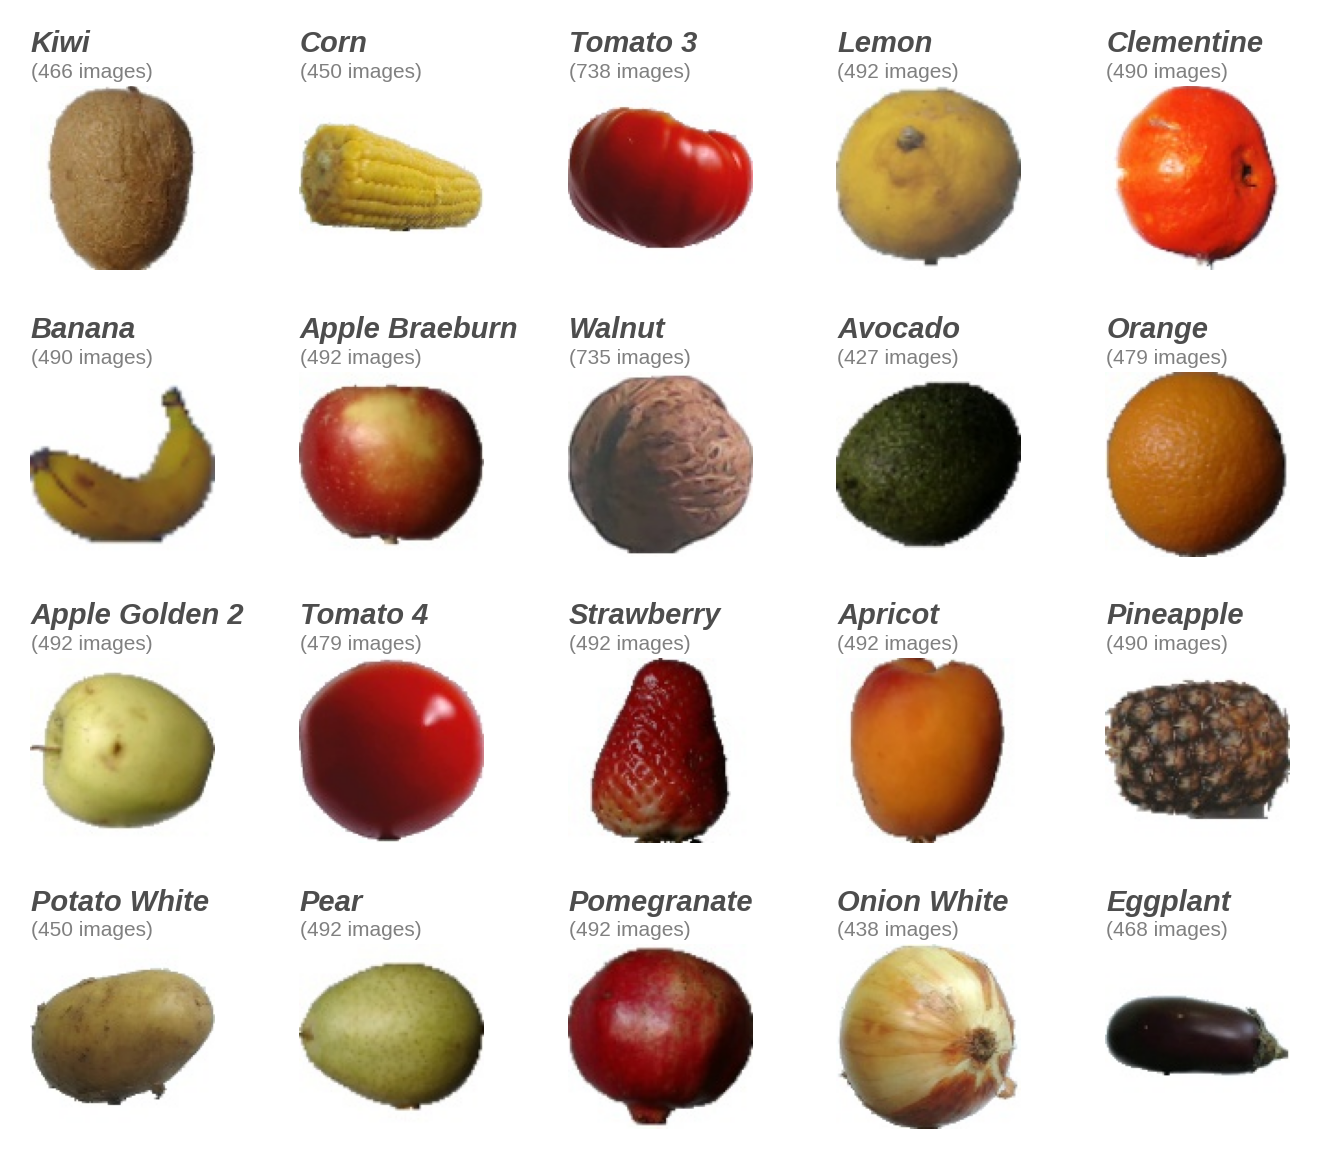

In [5]:
# @title
# display some random fruits

N_rows = 4  # rows and cols in the plot
N_cols = 5

train_classes = glob(train_dir + "/*")

# randomly select N_rows * N_cols fruits from train set
sampled_classes = random.sample(train_classes, N_rows*N_cols)

# reshape them as array N_rows by N_cols
sampled_classes = np.array(sampled_classes).reshape(N_rows, N_cols)

fig, axes = plt.subplots(N_rows, N_cols, figsize= (4.5,4), dpi= 300)

for row_id in range(N_rows):
    for col_id in range(N_cols):

        ax = axes[row_id, col_id]

        img_folder = sampled_classes[row_id, col_id]  # class folder
        img_folder_paths = glob(img_folder + '/*.jpg')  # list of img paths
        img_folder_size = len(img_folder_paths)  # number of images

        class_name = img_folder.split('/')[-1]

        # randomly choose an img file from folder
        img_path = random.choice(img_folder_paths)

        img = mpimg.imread(img_path)

        ax.imshow(img)

        # set two liner-title using annotate
        ax.annotate(f"{class_name}", xy=(0,-19),
                    color='0.3', annotation_clip=False,
                    fontsize=7, style='italic', fontweight='bold')

        ax.annotate(f"({img_folder_size} images)", xy=(0,-5),
                    color='gray', annotation_clip=False,
                    fontsize=5)

        ax.set_axis_off()
        ax.grid(False)

fig.tight_layout()
fig.savefig('Figures/fruits.jpg', dpi= 300)

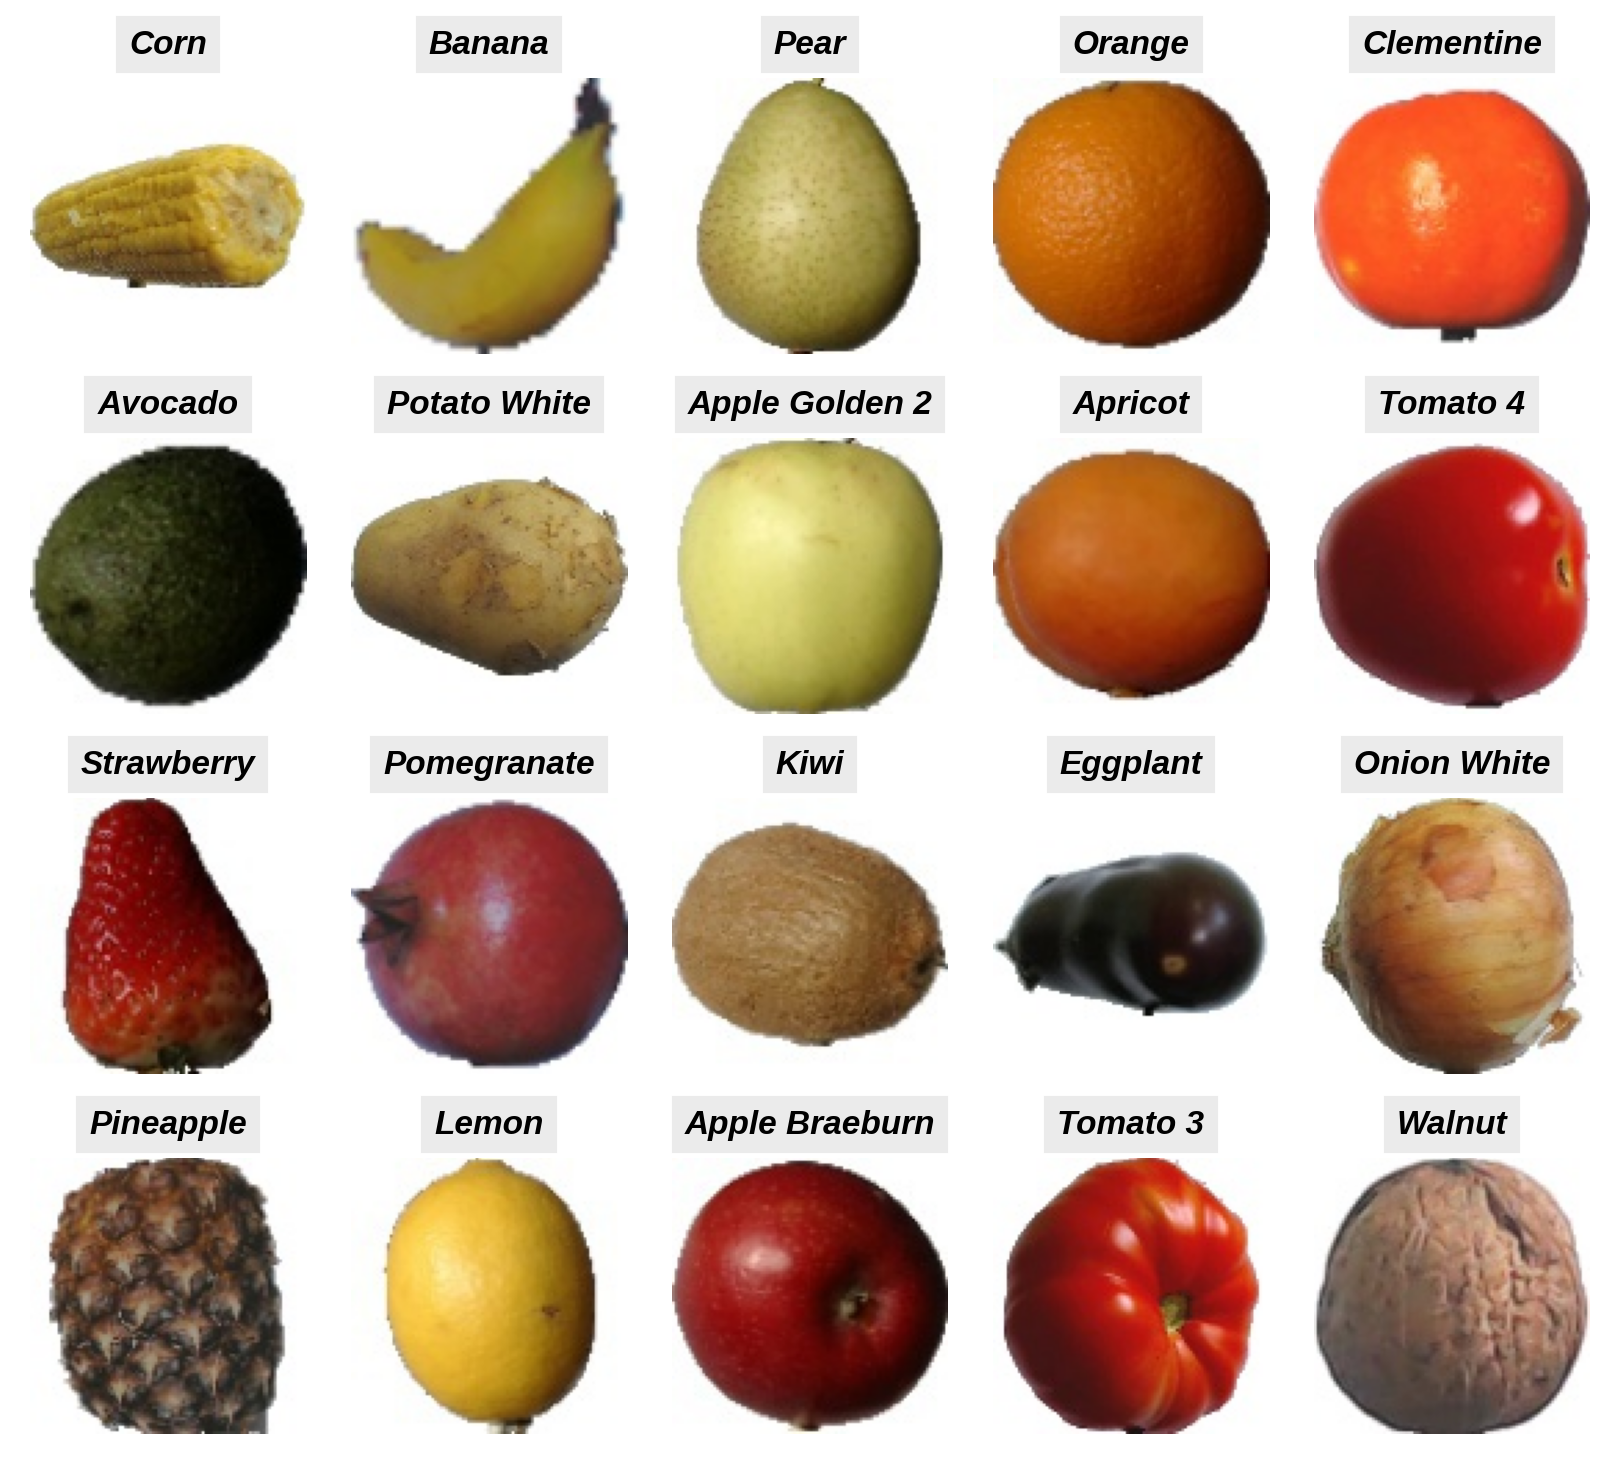

In [6]:
# @title
# THIS PRODUCES FIGURE FOR STREAMLIT APP
# DELETE THIS CELL ONCE DONE
# display some random fruits

N_rows = 4  # rows and cols in the plot
N_cols = 5

train_classes = glob(train_dir + "/*")

# randomly select N_rows * N_cols fruits from train set
sampled_classes = random.sample(train_classes, N_rows*N_cols)

# reshape them as array N_rows by N_cols
sampled_classes = np.array(sampled_classes).reshape(N_rows, N_cols)

fig, axes = plt.subplots(N_rows, N_cols, figsize= (5.5,5), dpi= 300)

for row_id in range(N_rows):
    for col_id in range(N_cols):

        ax = axes[row_id, col_id]

        img_folder = sampled_classes[row_id, col_id]  # class folder
        img_folder_paths = glob(img_folder + '/*.jpg')  # list of img paths
        img_folder_size = len(img_folder_paths)  # number of images

        class_name = img_folder.split('/')[-1]

        # randomly choose an img file from folder
        img_path = random.choice(img_folder_paths)


        img = mpimg.imread(img_path)

        ax.imshow(img)

        # set two liner-title using annotate
        ax.set_title(f"{class_name}",
                     color= '0.0',
                     backgroundcolor= '0.92',
                     fontsize= 8,
                     style= 'italic',
                     #fontfamily= 'Futura',
                     # Futura, Skia, Avenir, Tahoma, AppleGothic,
                     # Arial Rounded MT Bold, Comic Sans MS,
                     fontweight= 'bold',
                     )

        ax.set_axis_off()
        ax.grid(False)

fig.tight_layout()
fig.savefig('Figures/fruits_foreground.jpg', dpi= 500)

In [7]:
# number of image files
train_files = glob(train_dir + '/*/*.jpg')
test_files = glob(test_dir + '/*/*.jpg')

print(f'Images in train set: {len(train_files)}')
print(f'Images in test set: {len(test_files)}')

Images in train set: 10044
Images in test set: 3362


# Splitting Training, Validation, Test Set

In [8]:
# number of classes
N_classes = len(glob(train_dir + "/*"))

# resize image (height, width) < (100, 100)
# to speed up training process
img_height, img_width = 100, 100

# batch size to be used in fitting
batch_size = 32

- Traditionally, we would need to define X_train, X_valid, y_train and y_valid. However, instead, we will use `keras.utils.image_dataset_from_directory` method which creates `tf.data.Dataset` object. This method takes a directory as input and assigns class labels to its subdirectories (subfolder names). Each subdirectory must contain images from a single class for it to work.

- I will allocate 20% of the images in the training path for validation purposes.

In [11]:
# Allocate 20% of training set for validation
train_ds_raw = keras.utils.image_dataset_from_directory(
                train_dir,
                label_mode= 'categorical',
                validation_split= 0.2,
                subset= "training",  # use 80% of the split for training
                shuffle= True,
                seed= 777,
                image_size= (img_height, img_width),  # resize images
                batch_size= batch_size,
                )

Found 10044 files belonging to 20 classes.
Using 8036 files for training.


In [12]:
valid_ds_raw = keras.utils.image_dataset_from_directory(
                train_dir,
                label_mode= 'categorical',
                validation_split= 0.2,
                subset= "validation",  # use 20% of the split for validation
                shuffle= True,
                seed= 777,
                image_size= (img_height, img_width),  # resize images
                batch_size= batch_size,
                )

Found 10044 files belonging to 20 classes.
Using 2008 files for validation.


In [13]:
test_ds_raw = keras.utils.image_dataset_from_directory(
                test_dir,
                label_mode= 'categorical',
                shuffle= False,
                image_size= (img_height, img_width),  # resize images
                batch_size= batch_size,
                )

Found 3362 files belonging to 20 classes.


In [14]:
train_ds_raw

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None))>

Notes:
- I named them with trailing `..._raw` because datasets will be further preprocessed (pixel scaling etc.) by a specified preprocessing function that comes with each keras model.

- Note that `shuffle=True` for training and validation while `shuffle=False` for test set. This is because when a ds object is shuffled, true class labels and paths of images become inaccessible for some reason. I will need that info later in the model evaluation part to plot confusion matrix etc.  

# Preprocessing Batches

Images need to be preprocessed before passing to keras application model. People usually manually rescale pixel values by 1/255, however, recommended practice acc. to the [documentation](https://keras.io/api/applications/vgg/):

"*Note: each Keras Application expects a specific kind of input preprocessing. For VGG16, call `keras.applications.vgg16.preprocess_input` on your inputs before passing them to the model. `vgg16.preprocess_input` will convert the input images from RGB to BGR, then will zero-center each color channel with respect to the ImageNet dataset, without scaling.*"

`vgg16.preprocess_input()` takes tensor or array not dataset. Thus, write a function to apply it to `train_ds`, `valid_ds` and `test_ds`:

In [15]:
def preprocess_ds(ds, preprocess_method):
  """
  Preprocess a tf.data.Dataset object using the method
  that comes with the tf.keras.applications module
  e.g. preprocess_ds(train_ds, vgg16.preprocess_input)
  """

  # store class_names and file_paths before mapping
  # as some attributes are lost after mapping!
  class_names = ds.class_names
  file_paths = ds.file_paths

  ds = ds.map(lambda images, labels: (preprocess_method(images), labels))

  # reassign class_names attribute
  ds.class_names = class_names
  ds.file_paths = file_paths

  return ds

# Model Building

### VGG16

- Transfer learning of VGG-16 trained on ImageNet dataset. Remove the dense layers and add global average pooling 2D.  

- Add prediction layer matching the number of classes. Also add an optional intermediate dense layer before the prediction layer to significantly increase accuracy (increases computation time though!)

In [17]:
# @title
def make_vgg16_model():

  input_shape = (img_height, img_width, 3)

  model = Sequential()

  # Transfer learning of VGG-16
  base_model = vgg16.VGG16(
                  input_shape= input_shape,
                  include_top= False,  # remove top dense layers
                  weights= 'imagenet',  # use pretrained weights on imagenet
                  pooling= 'avg',  # output 2D tensor when pooling applied
                  )

  # Set base layers non-trainable
  base_model.trainable = False

  # Add base_model to our own model
  model.add(base_model)


  # Add intermediate dense layer to increase accuracy?
  model.add(Dense(128, activation= 'relu'))

  # Add fully connected output/classification layer
  model.add(Dense(N_classes, activation= 'softmax'))


  return model


Since we set the layers of the base model non-trainable, trainable params of the base layers is zero. We have only 68,244 trainable params associated with the dense layer(s) we added on top.

### ResNet50

In [18]:
def make_resnet50_model():

  input_shape = (img_height, img_width, 3)

  model = Sequential()

  # Transfer learning of ResNet50
  base_model = resnet50.ResNet50(
                  input_shape= input_shape,
                  include_top= False,  # remove top dense layers
                  weights= 'imagenet',  # use pretrained weights on imagenet
                  pooling= 'avg',  # output 2D tensor when pooling applied
                  )

  # Set base model non-trainable
  base_model.trainable = False

  # Add base_model to our own model
  model.add(base_model)


  # Add intermediate dense layer to increase accuracy?
  model.add(Dense(128, activation= 'relu'))

  # Add fully connected output/classification layer
  model.add(Dense(N_classes, activation= 'softmax'))


  return model

### Xception

In [19]:
def make_xception_model():

  input_shape = (img_height, img_width, 3)

  model = Sequential()

  # Transfer learning of Xception
  base_model = xception.Xception(
                  input_shape= input_shape,
                  include_top= False,  # remove top dense layers
                  weights= 'imagenet',  # use pretrained weights on imagenet
                  pooling= 'avg',  # output 2D tensor when pooling applied
                  )

  # Set base model non-trainable
  base_model.trainable = False

  # Add base_model to our own model
  model.add(base_model)


  # Add intermediate dense layer to increase accuracy?
  model.add(Dense(128, activation= 'relu'))

  # Add fully connected output/classification layer
  model.add(Dense(N_classes, activation= 'softmax'))


  return model

### EfficientNetB7

In [20]:
def make_efficientnetb7_model():

  input_shape = (img_height, img_width, 3)

  model = Sequential()

  # Transfer learning of EfficientNetB7
  base_model = efficientnet.EfficientNetB7(
                  input_shape= input_shape,
                  include_top= False,  # remove top dense layers
                  weights= 'imagenet',  # use pretrained weights on imagenet
                  pooling= 'avg',  # output 2D tensor when pooling applied
                  )

  # Set base model non-trainable
  base_model.trainable = False

  # Add base_model to our own model
  model.add(base_model)


  # Add intermediate dense layer to increase accuracy?
  model.add(Dense(128, activation= 'relu'))

  # Add fully connected output/classification layer
  model.add(Dense(N_classes, activation= 'softmax'))


  return model

# Training

In [21]:
# Set preprocess method before feeding data to model
# resnet50, vgg16, xception or efficientnet
preprocess_method = resnet50.preprocess_input

# Create a new model
model = make_resnet50_model()

model.summary()

# Preprocess image batches with specified method
train_ds = preprocess_ds(train_ds_raw, preprocess_method)
valid_ds = preprocess_ds(valid_ds_raw, preprocess_method)
test_ds = preprocess_ds(test_ds_raw, preprocess_method)

94765736/94765736 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 20)                2580      
                                                                 
Total params: 23852564 (90.99 MB)
Trainable params: 264852 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


Compile model

In [22]:
model.compile(optimizer= Adam(learning_rate= 0.0003),
              loss= 'categorical_crossentropy',
              metrics= ['accuracy'])

Train model and save training history

In [23]:
fit_history = model.fit(train_ds,
                        validation_data= valid_ds,
                        epochs= 10,
                        )

Epoch 1/10
252/252 [==============================] - 2340s 9s/step - loss: 0.2183 - accuracy: 0.9548 - val_loss: 0.0081 - val_accuracy: 1.0000
Epoch 2/10
252/252 [==============================] - 19s 76ms/step - loss: 0.0047 - accuracy: 1.0000 - val_loss: 0.0026 - val_accuracy: 1.0000
Epoch 3/10
252/252 [==============================] - 20s 77ms/step - loss: 0.0019 - accuracy: 1.0000 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 4/10
252/252 [==============================] - 19s 72ms/step - loss: 0.0010 - accuracy: 1.0000 - val_loss: 8.3252e-04 - val_accuracy: 1.0000
Epoch 5/10
252/252 [==============================] - 17s 67ms/step - loss: 6.5160e-04 - accuracy: 1.0000 - val_loss: 5.5844e-04 - val_accuracy: 1.0000
Epoch 6/10
252/252 [==============================] - 17s 67ms/step - loss: 4.4744e-04 - accuracy: 1.0000 - val_loss: 3.9937e-04 - val_accuracy: 1.0000
Epoch 7/10
252/252 [==============================] - 20s 77ms/step - loss: 3.2554e-04 - accuracy: 1.0000 - val_loss

Quick evaluation of model performance on test set

In [24]:
model.evaluate(test_ds)

106/106 [==============================] - 796s 8s/step - loss: 0.0609 - accuracy: 0.9816


[0.0608544684946537, 0.981558620929718]

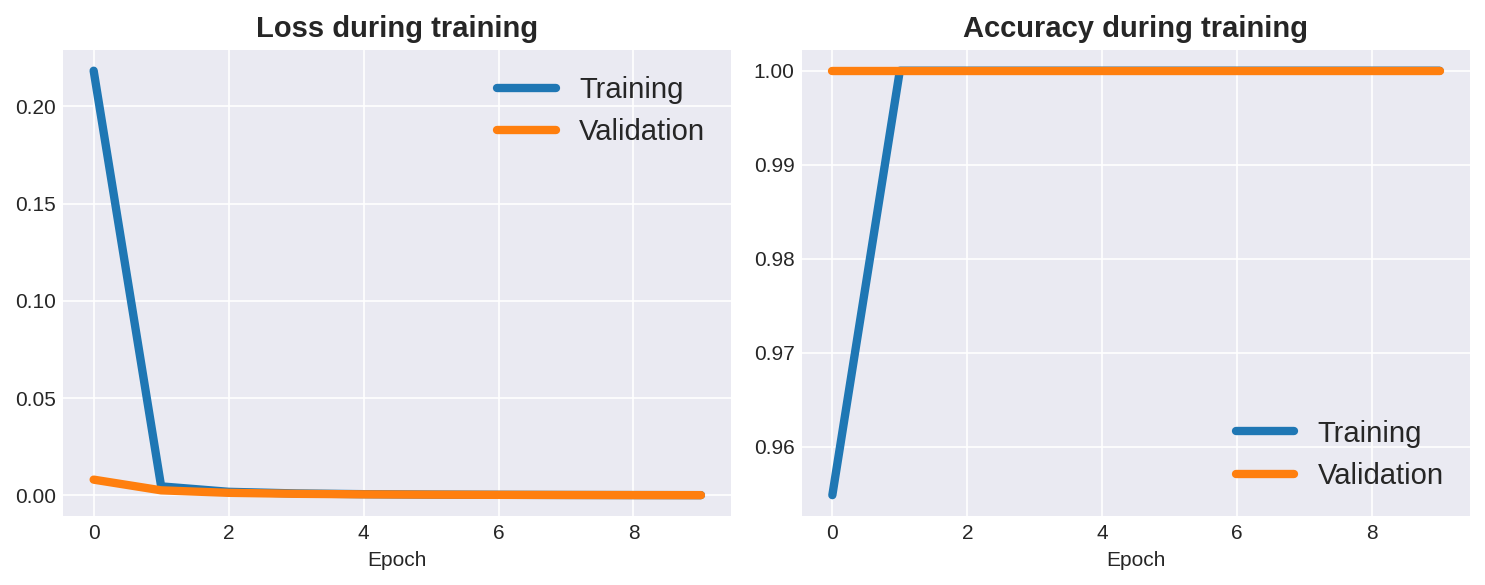

In [36]:
# @title
def plot_training_history(fit_history):
    '''
    Plots loss and accuracy vs. training epoch
    Input: fit_history = model.fit(...)
    Assumes accuracy has been passed to compile method
    e.g. model.compile(metrics=['accuracy', ..])
    '''

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4), dpi=150)

    # Loss vs. epoch
    ax1.plot(fit_history.history['loss'], label= 'Training', lw= 4)
    ax1.plot(fit_history.history['val_loss'], label= 'Validation', lw= 4)

    ax1.legend(fontsize=14)
    ax1.set_title('Loss during training', fontweight= 'bold', fontsize= 14)
    ax1.set_xlabel('Epoch')


    # Accuracy vs. epoch
    ax2.plot(fit_history.history['accuracy'], label= 'Training', lw= 4)
    ax2.plot(fit_history.history['val_accuracy'], label= 'Validation', lw= 4)

    ax2.legend(fontsize=14)
    ax2.set_title('Accuracy during training', fontweight= 'bold', fontsize= 14)
    ax2.set_xlabel('Epoch')

    fig.tight_layout()

plot_training_history(fit_history)

Save model (optional)

In [27]:
# OPTION-1:
# Save the entire model as h5 file
# fastest format when reloading model
# common format in the community
# not the recommended way anymore by keras doc
model.save("model.h5")

# OPTION-2:
# Save the entire model as a `.keras` zip archive
# recommended format by keras
# but slower than h5 format when reloading
# model.save("model.keras")

# OPTION-3:
# Export lightweight version of the model e.g. for deployment
# The only available attribute is model.serve()
# to make prediction, equivalent of model.predict()
# https://www.tensorflow.org/guide/keras/serialization_and_saving#exporting
# model.export("lightweight_model")

# OPTION-4:
# Using joblib
# joblib.dump(model, "model.sav")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Reload Saved Model (no training)

In [ ]:
# resnet50, vgg16, xception or efficientnet
preprocess_method = resnet50.preprocess_input

# Reload previously saved model
model = keras.models.load_model("resnet50_model.h5")
#model = joblib.load("resnet50_model.sav")

model.summary()

# Preprocess image batches with specified method
train_ds = preprocess_ds(train_ds_raw, preprocess_method)
valid_ds = preprocess_ds(valid_ds_raw, preprocess_method)
test_ds = preprocess_ds(test_ds_raw, preprocess_method)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_4 (Dense)             (None, 128)               262272    
                                                                 
 dense_5 (Dense)             (None, 20)                2580      
                                                                 
Total params: 23852564 (90.99 MB)
Trainable params: 264852 (1.01 MB)
Non-trainable params: 23587712 (89.98 MB)
_________________________________________________________________


# Model Evaluation

Predict class probabilities for test set

In [28]:
pred_probs_test = model.predict(test_ds)

# print probs of a random image
pred_probs_test[123]

106/106 [==============================] - 6s 44ms/step


array([9.9607253e-01, 2.1360868e-04, 1.2712216e-04, 2.1201720e-05,
       1.7082526e-05, 5.1656066e-06, 4.1412494e-07, 2.1323385e-05,
       1.2266023e-04, 2.8903812e-06, 8.7606412e-04, 1.2281789e-06,
       1.4869763e-03, 4.1132153e-04, 2.0547854e-04, 2.3630391e-06,
       3.9765725e-04, 1.2512899e-06, 1.3216627e-05, 5.3865983e-07],
      dtype=float32)

Probabilitites --> Predicted Class Indices

In [29]:
pred_indices_test = np.argmax(pred_probs_test, axis=-1)
pred_indices_test

array([ 0,  0,  0, ..., 19, 19, 19])

Predicted Class Indices --> Labels

In [30]:
# predicted labels must be mapped using train_ds.class_names
pred_labels_test = np.array([train_ds.class_names[ind]
                             for ind in pred_indices_test])

pred_labels_test

array(['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', ...,
       'Walnut', 'Walnut', 'Walnut'], dtype='<U14')

True Class Indices

In [31]:
true_indices_test = []

# unbatch test_ds to get individual images, labels
# loop over them to store their labels
for image, label in test_ds.unbatch():
    ohe_label = label.numpy()  # one-hot encoded label
    true_indices_test.append(np.argmax(ohe_label))

true_indices_test = np.array(true_indices_test)

true_indices_test

array([ 0,  0,  0, ..., 19, 19, 19])

 True Class Indices --> Labels

In [32]:
# true labels must be mapped using test_ds.class_names
true_labels_test = np.array([test_ds.class_names[ind]
                             for ind in true_indices_test])

true_labels_test

array(['Apple Braeburn', 'Apple Braeburn', 'Apple Braeburn', ...,
       'Walnut', 'Walnut', 'Walnut'], dtype='<U14')

### Accuracy

In [33]:
# print train, valid, test accuracy
train_accuracy = model.evaluate(train_ds)[1]
valid_accuracy = model.evaluate(valid_ds)[1]
test_accuracy = model.evaluate(test_ds)[1]

print()
print(f'Train accuracy: {train_accuracy:.2f}')
print(f'Validation accuracy: {valid_accuracy:.2f}')
print(f'Test accuracy: {test_accuracy:.2f}')

106/106 [==============================] - 6s 51ms/step - loss: 0.0609 - accuracy: 0.9816

Train accuracy: 1.00
Validation accuracy: 1.00
Test accuracy: 0.98


### Precision, Recall, F1-Score

In [34]:
class_report = metrics.classification_report(
                    true_labels_test,
                    pred_labels_test)

print(class_report)

                precision    recall  f1-score   support

Apple Braeburn       1.00      1.00      1.00       164
Apple Golden 2       0.88      1.00      0.94       164
       Apricot       1.00      1.00      1.00       164
       Avocado       0.86      1.00      0.93       143
        Banana       1.00      1.00      1.00       166
    Clementine       1.00      1.00      1.00       166
          Corn       1.00      0.90      0.95       150
      Eggplant       1.00      0.85      0.92       156
          Kiwi       1.00      1.00      1.00       156
         Lemon       0.98      1.00      0.99       164
   Onion White       0.95      0.99      0.97       146
        Orange       1.00      1.00      1.00       160
          Pear       1.00      0.87      0.93       164
     Pineapple       0.99      1.00      0.99       166
   Pomegranate       1.00      1.00      1.00       164
  Potato White       0.98      1.00      0.99       150
    Strawberry       0.99      1.00      1.00  

### Confusion Matrix

<Figure size 640x480 with 0 Axes>

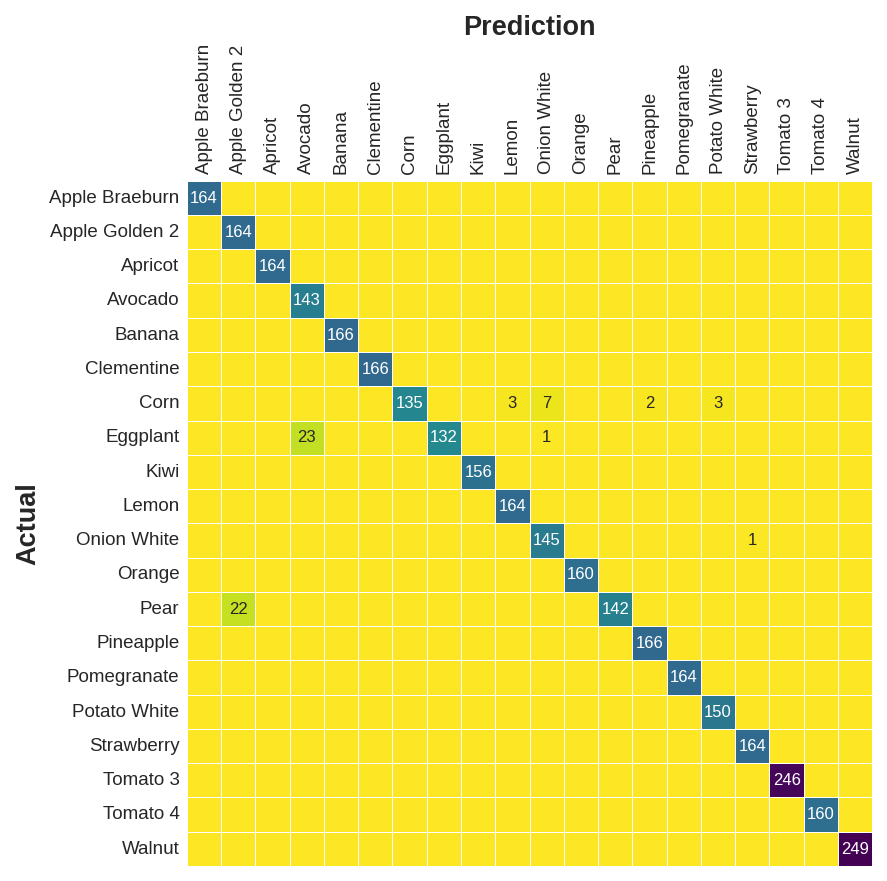

In [35]:
# @title
def plot_confusion_matrix(true_labels, pred_labels):
    '''
    Plot confusion matrix from labels (not from indices)
    '''

    cmat = metrics.ConfusionMatrixDisplay.from_predictions(
                                    true_labels, pred_labels)
    # ConfusionMatrixDisplay generates its own fig,
    # but I will only get the data and the labels and then
    # will clear the fig and create a new fig using sns.heatmap

    cmat_data = cmat.confusion_matrix
    # Confusion matrix whose i-th row and j-th column entry indicates
    # the number of samples with true label being i-th class
    # and predicted label being j-th class.

    # get class labels
    cmat_labels = cmat.display_labels

    # clear current fig
    plt.clf()


    fig, ax = plt.subplots(figsize= (6,6), dpi= 150)

    # good cmaps: viridis_r, magma_r
    sns.heatmap(data= cmat_data, ax= ax,
                xticklabels= cmat_labels,
                yticklabels= cmat_labels,
                square= True, annot= True, fmt= 'd',
                cbar= False, cmap= 'viridis_r',
                linewidths= 0.4, annot_kws= {'fontsize': 8})

    # turn off annotation of cell values with 0
    # to reduce clutter in the plot
    for text in ax.texts:
        cell_value = float(text.get_text())
        if  cell_value == 0:
            text.set_text('')

    ax.set_xlabel('Prediction', fontsize= 13, fontweight= 'bold')
    ax.set_ylabel('Actual', fontsize= 13,  fontweight= 'bold')

    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    ax.tick_params(axis= 'both', labelsize= 9)
    plt.xticks(rotation= 90, ha= 'center')

    fig.tight_layout()
    fig.savefig('Figures/confusion_matrix.jpg', dpi= 300)


plot_confusion_matrix(true_labels_test, pred_labels_test)

### Correctly Classified Images

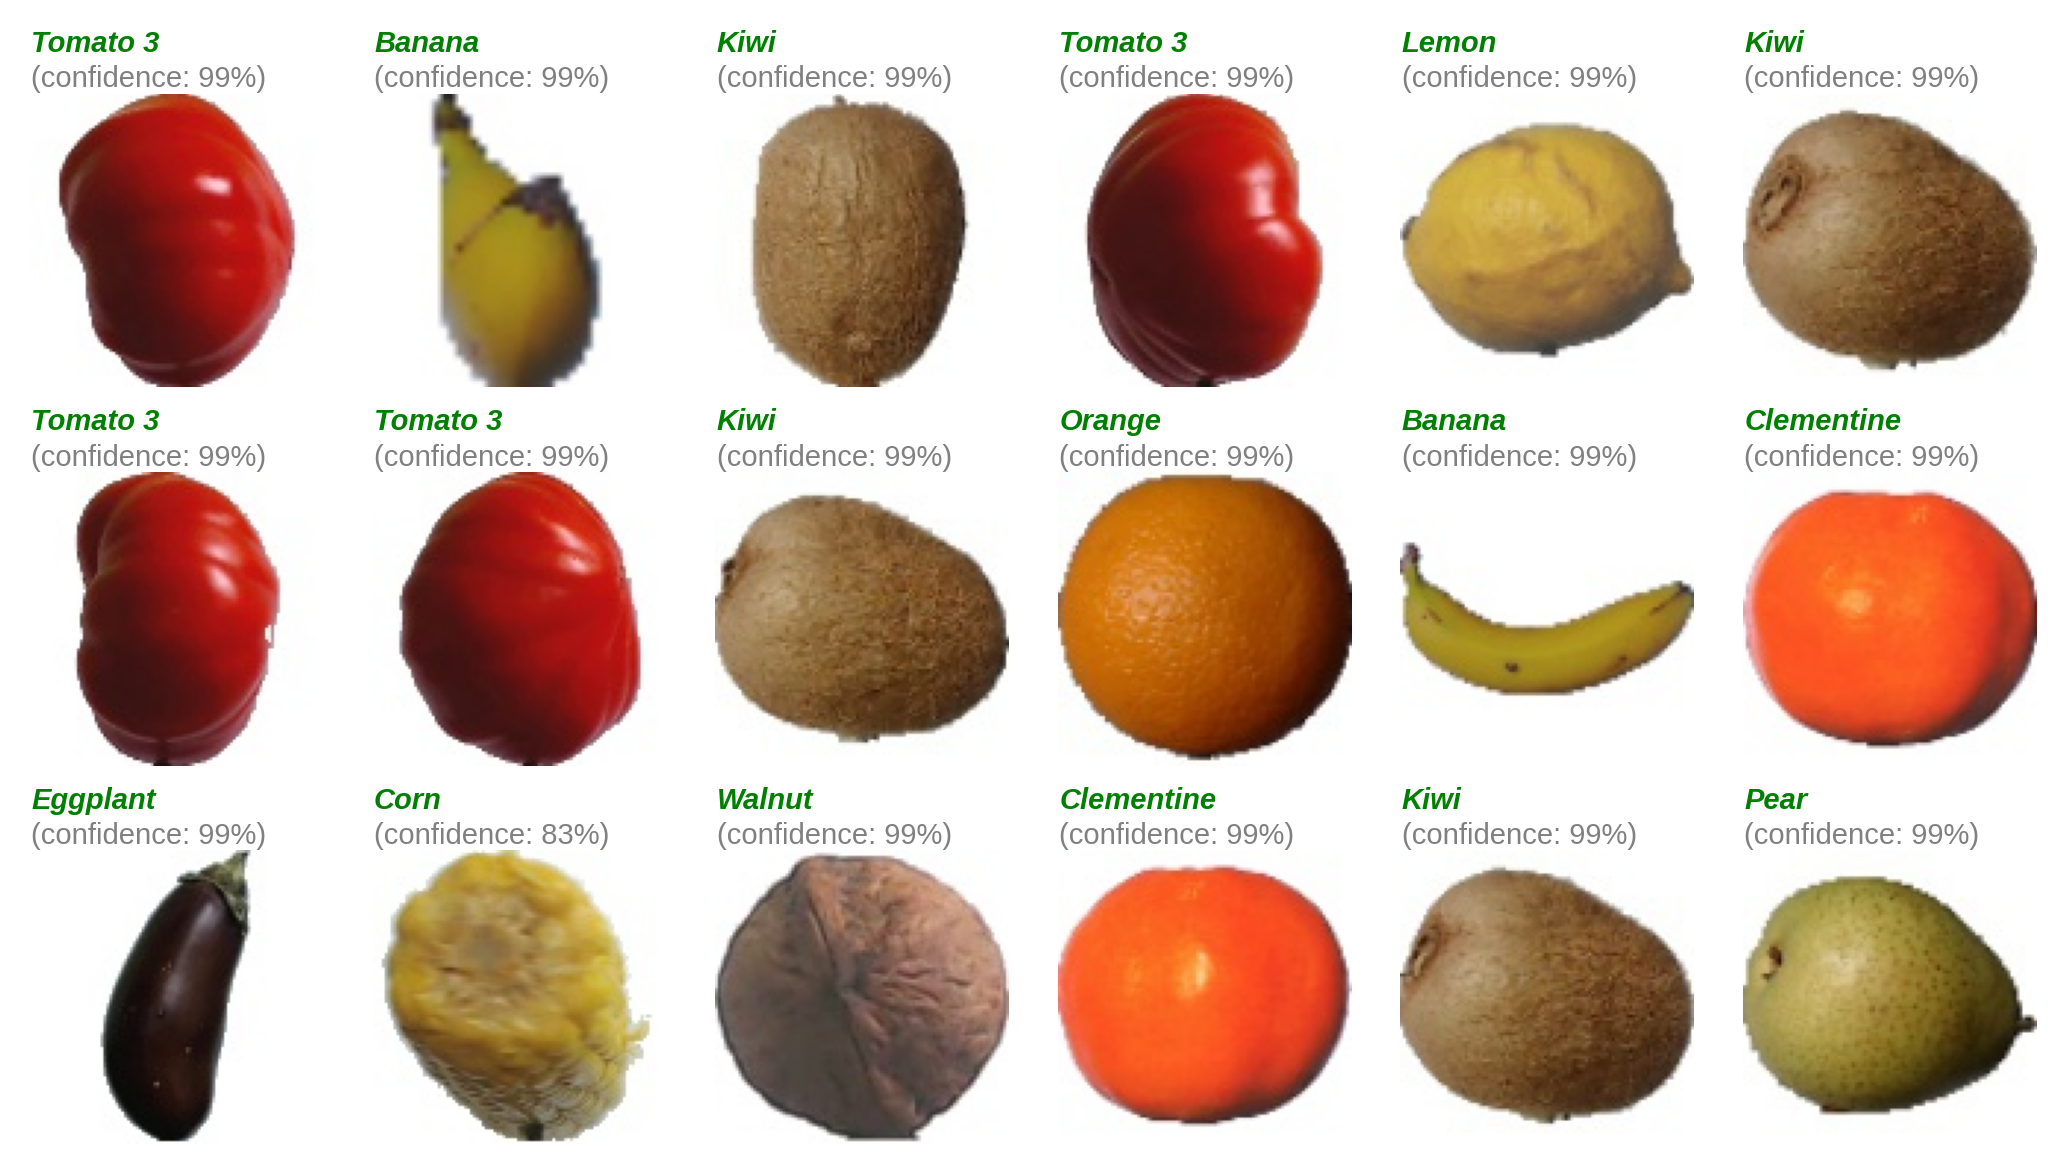

In [37]:
# @title
# display some random correctly classified images

N_rows = 3  # rows and cols in the plot
N_cols = 6

if_match = (true_indices_test == pred_indices_test)
mismatch_files = [index for index, value
                  in enumerate(if_match) if value == True]

# randomly select N_rows * N_cols files from mismatch files
sampled_files = random.sample(mismatch_files, N_rows*N_cols)

# reshape them as array N_rows by N_cols
sampled_files = np.array(sampled_files).reshape(N_rows, N_cols)

fig, axes = plt.subplots(N_rows, N_cols, figsize= (7,4), dpi= 300)

for row_id in range(N_rows):
    for col_id in range(N_cols):

        ax = axes[row_id, col_id]

        img_index = sampled_files[row_id, col_id]
        img_path = test_ds.file_paths[img_index]

        true_class_index = true_indices_test[img_index]
        true_class_label = true_labels_test[img_index]
        pred_confidence = int(pred_probs_test
                              [img_index, true_class_index] *100)

        img = mpimg.imread(img_path)

        ax.imshow(img)

        ax.annotate(f"{true_class_label}", xy=(0,-15),
                    color='green', annotation_clip=False,
                    fontsize=7, style='italic', fontweight='bold')

        ax.annotate(f"(confidence: {pred_confidence}%)", xy=(0,-3),
                    color='gray', annotation_clip=False,
                    fontsize=7)

        ax.set_axis_off()
        ax.grid(False)

fig.tight_layout()
fig.savefig('Figures/classified_correct.jpg', dpi= 300)

<u>Comments</u>:
- Note that the fruits that have similar look along different axes are predicted with high confidence such as walnut and orange.

- Fruits that have totally different look from different axes are predicted with lower confidence e.g. algo is having some hard time in recognizing corn when pic is along or close to its long axis.

### Misclassified Images

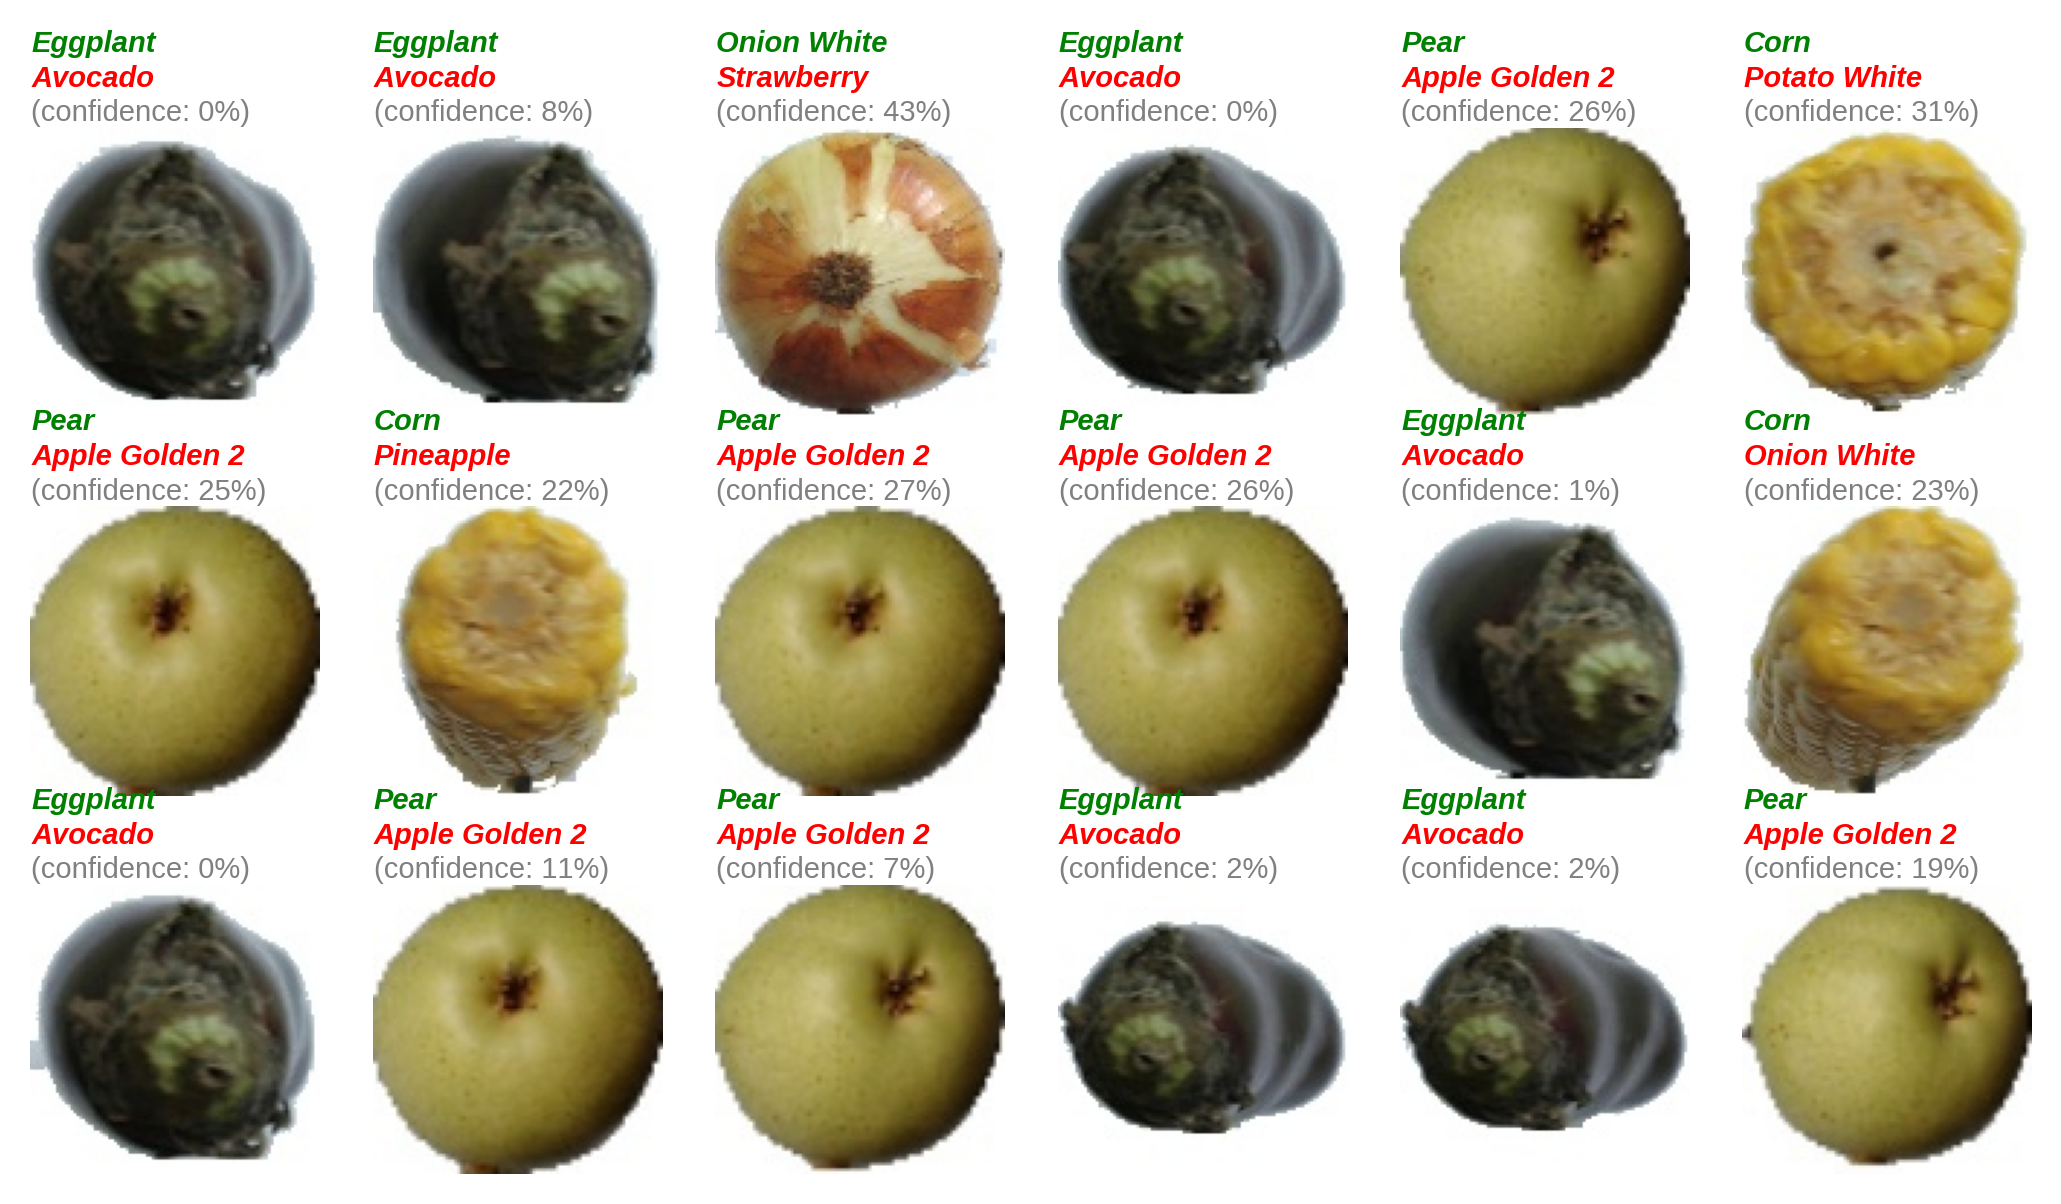

In [38]:
# @title
# display some random misclassified images

N_rows = 3  # rows and cols in the plot
N_cols = 6

if_match = (true_indices_test == pred_indices_test)
mismatch_files = [index for index, value in
                  enumerate(if_match) if value == False]

# randomly select N_rows * N_cols files from mismatch files
sampled_files = random.sample(mismatch_files, N_rows*N_cols)

# reshape them as array N_rows by N_cols
sampled_files = np.array(sampled_files).reshape(N_rows, N_cols)

fig, axes = plt.subplots(N_rows, N_cols, figsize= (7,4), dpi= 300)

for row_id in range(N_rows):
    for col_id in range(N_cols):

        ax = axes[row_id, col_id]

        img_index = sampled_files[row_id, col_id]
        img_path = test_ds.file_paths[img_index]

        true_class_index = true_indices_test[img_index]
        true_class_label = true_labels_test[img_index]
        pred_class_label = pred_labels_test[img_index]
        pred_confidence = int(pred_probs_test
                              [img_index, true_class_index] *100)

        img = mpimg.imread(img_path)

        ax.imshow(img)

        ax.annotate(f"{true_class_label}", xy=(0,-27),
                    color='green', annotation_clip=False,
                    fontsize=7, style='italic', fontweight='bold')

        ax.annotate(f"{pred_class_label}", xy=(0,-15),
                    color='red', annotation_clip=False,
                    fontsize=7, style='italic', fontweight='bold')

        ax.annotate(f"(confidence: {pred_confidence}%)", xy=(0,-3),
                    color='gray', annotation_clip=False,
                    fontsize=7)

        ax.set_axis_off()
        ax.grid(False)

fig.tight_layout()
fig.savefig('Figures/classified_wrong.jpg', dpi= 300)

<u>Comments</u>:
- Most of the misclassified classes belong to corn especially when the pic is along its long axis. We can add more pics of corn taken along/close to its long axis to remedy this. Similar goes for eggplant.

- When a fruit is confused with some other fruit, it turns out "Onion White" is the first choice of the model for some reason. We might need more data from "Onion White" to improve the model.

# Predict Single Image

I will remove background of images with confusing background. Since my training set has a unique plain white background it will be challenging for the model to make correct predictions for the images having colored background.  

In [39]:
def remove_background(image_path, display= False):
    '''
    Replace background with plain white
    using PIL, rembg libraries
    Return BytesIO temp path of converted img
    Optionally display converted img
    '''

    # Load the input image
    input = PIL.Image.open(image_path)

    # Replace background with white
    output = rembg.remove(input, bgcolor=(255,255,255,255))

    # Convert from RGBA to RGB
    output_rgb = output.convert('RGB')

    # Display converted image
    if display:
        plt.imshow(output_rgb)
        plt.grid(False)

    # Create temp path in memory to save bg-removed img
    temp_path = io.BytesIO()

    # Save to temp path
    output_rgb.save(temp_path, format= 'jpeg')

    return temp_path

In [40]:
def predict_single_image(image_path, model, preprocess_method):
    '''
    Predict class label of a single image
    If img not square, will be cropped in the center
    and resized to target size inferred from the model
    Apply preprocess_method that comes with the
    keras.applications module e.g. vgg16.preprocess_input
    '''

    # get the target image size from model
    target_size = model.input_shape[1:3]

    # load image file
    img = keras.utils.load_img(image_path,
                               target_size= target_size,
                               keep_aspect_ratio= True, # crop in the center
                               )

    # convert img object to 3D np.array
    # -> (height,width,channel)
    img_array = keras.utils.img_to_array(img)

    # preprocess img_array using the provided preprocess_method
    preprocessed_array = preprocess_method(img_array)

    # model expects 4-dim tensor input, so add an extra dim
    # -> (1,height,width,channel)
    img_tensor = np.expand_dims(preprocessed_array, axis=0)

    # make prediction
    pred_probs_single = model.predict(img_tensor)
    pred_indices_single = np.argmax(pred_probs_single, axis=-1)

    pred_labels_single = np.array([train_ds.class_names[ind]
                                for ind in pred_indices_single])

    #pred_labels_single = indices_to_labels(pred_indices_single, train_ds)

    confidence = int(pred_probs_single[0, pred_indices_single[0]] *100)

    print(f"{pred_labels_single[0]} ({confidence}%)")

    # show image
    plt.imshow(img)
    plt.grid(False)

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 127GB/s]


1/1 [==============================] - 1s 1s/step
Corn (99%)


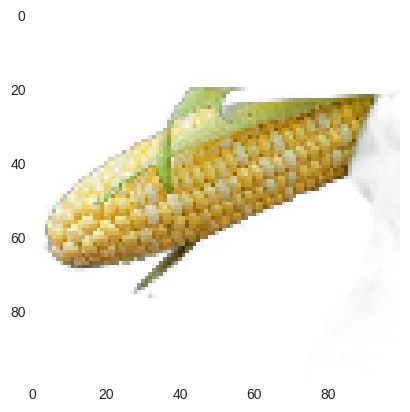

In [41]:
# Try some novel images

novel_path = "fruits-360_dataset_trimmed/Novel_Images"

#im_path = join(novel_path, 'IMG_7642.jpeg')
im_path = join(novel_path, 'corn_4.jpg')

#im_path = remove_background(im_path)
im_path = remove_background(im_path)
predict_single_image(im_path, model, preprocess_method)

# EXPERIMENTAL

# TO DO

- image augmentation e.g. zoom, rotate, mirror, shift https://machinelearningmastery.com/image-augmentation-deep-learning-keras/

- too many samples for test set. create val set from test set.

- try to use different background removal methods such as the GrabCut algorithm from opencv